## Human Resource Analytics

### Summary
#### The project goal is to understand what factors contribute most to employee turnover and create a model that can predict if a certain employee will leave the company or not

In [1]:
# read in modules
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

### 1. Data Quality Check

In [2]:
# read in data
data = pd.read_csv("HR_comma_sep.csv")

In [3]:
data.head(10)

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,sales,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low
5,0.41,0.50,2,153,3,0,1,0,sales,low
6,0.10,0.77,6,247,4,0,1,0,sales,low
7,0.92,0.85,5,259,5,0,1,0,sales,low
8,0.89,1.00,5,224,5,0,1,0,sales,low
9,0.42,0.53,2,142,3,0,1,0,sales,low


In [4]:
data.shape

(14999, 10)

In [5]:
# Check if there is any missing value, no missing value
data.isnull().sum()

satisfaction_level       0
last_evaluation          0
number_project           0
average_montly_hours     0
time_spend_company       0
Work_accident            0
left                     0
promotion_last_5years    0
sales                    0
salary                   0
dtype: int64

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 10 columns):
satisfaction_level       14999 non-null float64
last_evaluation          14999 non-null float64
number_project           14999 non-null int64
average_montly_hours     14999 non-null int64
time_spend_company       14999 non-null int64
Work_accident            14999 non-null int64
left                     14999 non-null int64
promotion_last_5years    14999 non-null int64
sales                    14999 non-null object
salary                   14999 non-null object
dtypes: float64(2), int64(6), object(2)
memory usage: 1.1+ MB


### 2. Data Exploration

In [7]:
# import plotly
import plotly
import plotly.plotly as py
import plotly.graph_objs as go

In [8]:
data.describe()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years
count,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000
mean,0.612834,0.716102,3.803054,201.050337,3.498233,0.144610,0.238083,0.021268
std,0.248631,0.171169,1.232592,49.943099,1.460136,0.351719,0.425924,0.144281
min,0.090000,0.360000,2.000000,96.000000,2.000000,0.000000,0.000000,0.000000
25%,0.440000,0.560000,3.000000,156.000000,3.000000,0.000000,0.000000,0.000000
50%,0.640000,0.720000,4.000000,200.000000,3.000000,0.000000,0.000000,0.000000
75%,0.820000,0.870000,5.000000,245.000000,4.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,7.000000,310.000000,10.000000,1.000000,1.000000,1.000000


#### Histogram of Employee Churn, 3,571 of 14,999 employees left

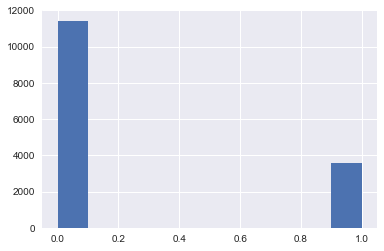

In [9]:
data['left'].astype('category').hist()

In [10]:
data['left'].value_counts()

0    11428
1     3571
Name: left, dtype: int64

#### Correlation Plot for Numeric Predictors

In [11]:
corr = data.corr()

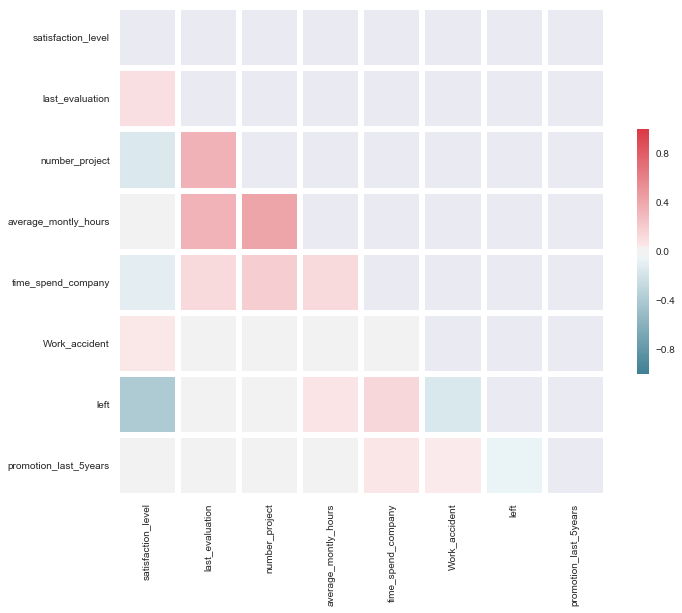

In [12]:
# generate a mask for the upper triangle
mask = np.zeros_like(corr,dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# set up the matplotlib figure
f, ax = plt.subplots(figsize=(11,9))

# generate a custom diverging colormap
cmap = sns.diverging_palette(220,10,as_cmap=True)

# draw the heatmap with the mask and corect aspect ratio
sns.heatmap(corr,mask=mask,cmap=cmap,vmax=1,center=0,
            square=True,linewidths=5,cbar_kws={"shrink":.5})

#### Employee Churn by Categorical Predictors

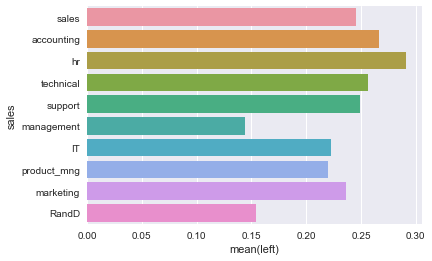

In [13]:
ax = sns.barplot(x="left", y="sales", data=data, ci=None)

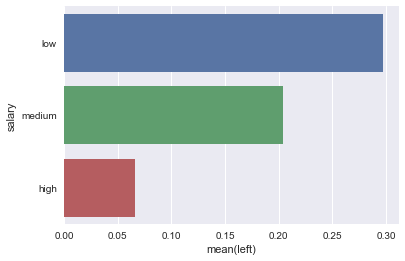

In [14]:
ax = sns.barplot(x="left", y="salary", data=data, ci=None)

In [15]:
# get dummy variables
data = pd.get_dummies(data)

### 3. Modeling

In [19]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import cross_validation, metrics
from sklearn.grid_search import GridSearchCV

In [17]:
# Stratified Sampling based on 'left'
predictors = [x for x in data.columns if x not in ['left']]

In [18]:
from sklearn.cross_validation import train_test_split
X = data[predictors]
y = data['left']
X_train, X_test, y_train, y_test = train_test_split(X,y,
                                                   stratify=y,test_size=0.25)

In [32]:
# separate existing employee
existEmployee = data[data.left==0].drop('left',axis=1)

In [41]:
# define model function
def modelfit(alg, dtrainX, dtrainY, dtestX, dtestY, existEmployee, predictors, performCV=True, printFeatureImportance=True, cv_folds=5):
    # fit the algorithm on the data
    alg.fit(dtrainX,dtrainY)
    
    # predict training set
    dtest_predictions = alg.predict(dtestX)
    dtest_predprob = alg.predict_proba(dtestX)[:,1]
    existEmployee_predprob = alg.predict_proba(existEmployee)[:,1]
    
    # perform cross-validation
    if performCV:
        cv_score = cross_validation.cross_val_score(alg, dtrainX, dtrainY, cv=cv_folds, scoring='roc_auc')
    
    # print model report
    print ("\nModel Report")
    print ("Accuracy : %.4g" % metrics.accuracy_score(dtestY.values, dtest_predictions))
    print ("AUC Score (Train): %f" % metrics.roc_auc_score(dtestY, dtest_predprob))
    
    if performCV:
        print ("CV Score: Mean - %.7g | Std - %.7g | Min - %.7g | Max - %.7g" % 
               (np.mean(cv_score),np.std(cv_score),np.min(cv_score),np.max(cv_score)))
    
    # print feature importance
    if printFeatureImportance:
        feat_imp = pd.Series(alg.feature_importances_, predictors).sort_values(ascending=False)
        feat_imp.plot(kind='bar', title='Feature Importances')
        plt.ylabel('Feature Importance Score')
        
    return existEmployee_predprob


Model Report
Accuracy : 0.9736
AUC Score (Train): 0.986421
CV Score: Mean - 0.9886185 | Std - 0.002044335 | Min - 0.9853919 | Max - 0.9907783


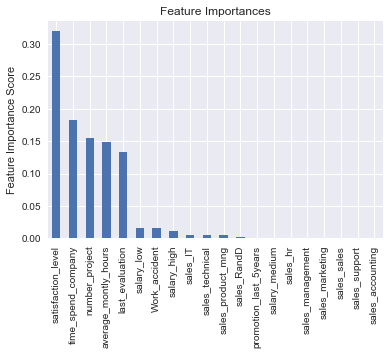

In [42]:
# train the model
ExistEmployeeChurn = modelfit(GradientBoostingClassifier(random_state=10), X_train, y_train, X_test, y_test, 
                              existEmployee, predictors)

In [45]:
existEmployee['left_prob'] = ExistEmployeeChurn

In [49]:
existEmployee = existEmployee.sort_values('left_prob', ascending=False)

In [50]:
existEmployee.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,promotion_last_5years,sales_IT,sales_RandD,sales_accounting,...,sales_management,sales_marketing,sales_product_mng,sales_sales,sales_support,sales_technical,salary_high,salary_low,salary_medium,left_prob
6466,0.39,0.57,2,132,3,0,0,0,0,0,...,0,0,0,0,1,0,0,1,0,0.971847
9781,0.42,0.50,2,151,3,0,0,0,0,0,...,0,0,0,1,0,0,0,1,0,0.967428
3780,0.86,0.96,5,238,5,0,0,0,0,0,...,0,0,0,0,0,1,0,1,0,0.940801
10098,0.73,0.83,5,266,5,0,0,0,0,0,...,0,0,0,1,0,0,0,1,0,0.936324
5565,0.84,0.84,6,261,5,0,0,0,0,0,...,0,0,1,0,0,0,0,1,0,0.935960


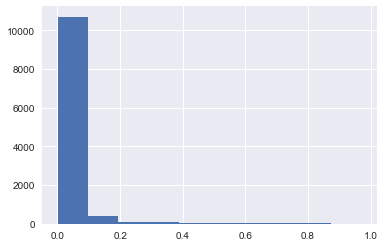

In [51]:
# plot the distribution of probablity churn
existEmployee['left_prob'].hist()